## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

Import

In [9]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

### Data Load

In [10]:
# 데이터 로드
IVF_train = pd.read_csv('../data/IVF_train_dataset_16.csv')
IVF_test = pd.read_csv('../data/IVF_test_dataset_16.csv')

DI_train = pd.read_csv('../data/DI_train_dataset.csv')
DI_test = pd.read_csv('../data/DI_test_dataset.csv')

# Total_train = pd.read_csv('train_eda_code_14.csv')
# Total_test = pd.read_csv('test_eda_code_14.csv')

In [11]:
# ID 열을 제외한 특성과 타겟 변수 분리
IVF_X = IVF_train.drop(['임신_성공_여부', 'ID'], axis=1)
IVF_y = IVF_train['임신_성공_여부']

DI_X = DI_train.drop(['임신_성공_여부', 'ID'], axis=1)
DI_y = DI_train['임신_성공_여부']

# Total_X = Total_train.drop(['임신_성공_여부', 'ID'], axis=1)
# Total_y = Total_train['임신_성공_여부']

### 인코딩 

In [12]:
IVF_categorical_columns = [
    "시술_시기_코드",
    "시술_당시_나이",
    "임신_시도_또는_마지막_임신_경과_연수",
    "배란_유도_유형",
    "난자_출처",
    "정자_출처",
    "난자_기증자_나이",
    "정자_기증자_나이",
    "난자_채취_경과일",
    "난자_해동_경과일",
    "난자_혼합_경과일",
    "배아_이식_경과일",
    "배아_해동_경과일",
    "변환된_특정_시술_유형"
]


In [13]:
DI_categorical_columns = [
    "시술_시기_코드",
    "시술_당시_나이",
    "임신_시도_또는_마지막_임신_경과_연수",
    "정자_기증자_나이",
    "변환된_특정_시술_유형"
]

In [14]:
# 모든 범주형 변수를 문자열로 변환
IVF_X[IVF_categorical_columns] = IVF_X[IVF_categorical_columns].astype(str)
DI_X[DI_categorical_columns] = DI_X[DI_categorical_columns].astype(str)
IVF_test[IVF_categorical_columns] = IVF_test[IVF_categorical_columns].astype(str)
DI_test[DI_categorical_columns] = DI_test[DI_categorical_columns].astype(str)

# OrdinalEncoder를 사용하여 범주형 변수 인코딩
IVF_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
DI_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

IVF_X[IVF_categorical_columns] = IVF_encoder.fit_transform(IVF_X[IVF_categorical_columns])
DI_X[DI_categorical_columns] = DI_encoder.fit_transform(DI_X[DI_categorical_columns])
IVF_test[IVF_categorical_columns] = IVF_encoder.transform(IVF_test[IVF_categorical_columns])
DI_test[DI_categorical_columns] = DI_encoder.transform(DI_test[DI_categorical_columns])

## Modeling

In [15]:
# 데이터 분할
IVF_X_train, IVF_X_test, IVF_y_train, IVF_y_test = train_test_split(IVF_X, IVF_y, test_size=0.2, random_state=42)
DI_X_train, DI_X_test, DI_y_train, DI_y_test = train_test_split(DI_X, DI_y, test_size=0.2, random_state=42)

Best trial:  
  Value: 0.7265399737876802  
  Params:   
    iterations: 2746  
    depth: 6  
    learning_rate: 0.02714910886494123  
    l2_leaf_reg: 0.9438940902410613  
    bagging_temperature: 0.05474176562660327  
    random_strength: 6.694445412295597  
    scale_pos_weight: 3.5493379241640897  
    border_count: 183  

---

### IVF 데이터


--- Model Performance ---
Model Accuracy: 0.7071244326248225
Model F1 Score: 0.4802895362452542
Model AUC: 0.7408998919840405


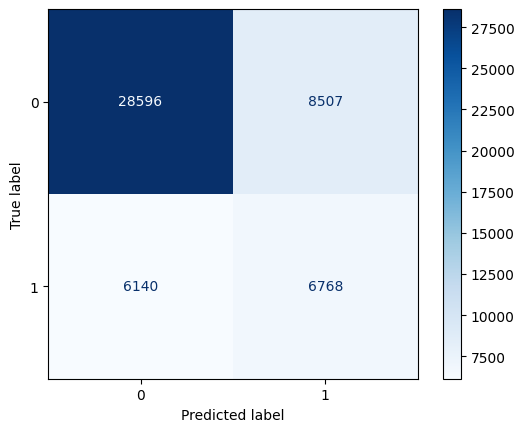

In [16]:
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 첫 번째 모델 초기화 (CatBoost)
IVF_model_catboost = CatBoostClassifier(
    iterations=1695,
    depth=4,
    learning_rate=0.05409861221944563,
    l2_leaf_reg=2.8407951389685064,
    bagging_temperature=0.3683084175511176,
    random_strength=1.1750568527543825,
    scale_pos_weight=3.3095659416645313,
    border_count=92,
    logging_level='Silent',
    random_state=42
)

# 두 번째 모델 초기화 (LightGBM)
IVF_model_lgb = lgb.LGBMClassifier(
    n_estimators=1258,
    num_leaves=923,
    max_depth=5,
    learning_rate=0.024413717866391526,
    min_child_samples=105,
    subsample=0.4890106069104924,
    colsample_bytree=0.4494069713807123,
    reg_alpha=3.0197481977859035,
    reg_lambda=0.4793565720612017,
    min_split_gain=0.29685405151668676,
    random_state=42,
    boosting_type='gbdt',
    verbose=-1
)

# 모델 학습
IVF_model_catboost.fit(IVF_X_train, IVF_y_train, eval_set=[(IVF_X_test, IVF_y_test)], verbose=False)
IVF_model_lgb.fit(IVF_X_train, IVF_y_train)

# 예측 확률 계산
y_pred_proba_catboost = IVF_model_catboost.predict_proba(IVF_X_test)[:, 1]
y_pred_proba_lgb = IVF_model_lgb.predict_proba(IVF_X_test)[:, 1]

# 소프트 보팅
y_pred_proba_combined = (y_pred_proba_catboost + y_pred_proba_lgb) / 2
y_pred_combined = (y_pred_proba_combined >= 0.5).astype(int)

# 평가
accuracy = accuracy_score(IVF_y_test, y_pred_combined)
f1 = f1_score(IVF_y_test, y_pred_combined)
auc = roc_auc_score(IVF_y_test, y_pred_proba_combined)
cm = confusion_matrix(IVF_y_test, y_pred_combined)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=IVF_model_catboost.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### DI 데이터


--- Model Performance ---
Model Accuracy: 0.8664546899841018
Model F1 Score: 0.0
Model AUC: 0.7278560506771516


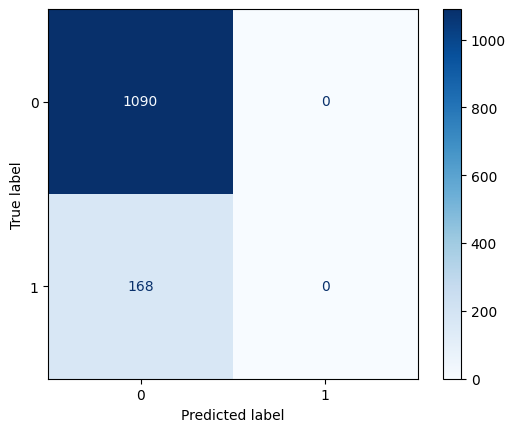

In [17]:
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 첫 번째 모델 초기화 (LightGBM)
DI_model_lgb = lgb.LGBMClassifier(
    n_estimators=2443,
    num_leaves=280,
    max_depth=149,
    learning_rate=0.061743249432816755,
    min_child_samples=176,
    subsample=0.9103802819067428,
    colsample_bytree=0.6636673663468106,
    reg_alpha=0.01173260476029451,
    reg_lambda=59.000778013447324,
    min_split_gain=1.1755604684312402,
    random_state=42,
    boosting_type='gbdt',
    verbose=-1
)

# 두 번째 모델 초기화 (CatBoost)
DI_model_catboost = CatBoostClassifier(
    iterations=2746,
    depth=6,
    learning_rate=0.02714910886494123,
    l2_leaf_reg=0.9438940902410613,
    bagging_temperature=0.05474176562660327,
    random_strength=6.694445412295597,
    scale_pos_weight=3.5493379241640897,
    border_count=183,
    logging_level='Silent',
    random_state=42
)

# 모델 학습
DI_model_lgb.fit(DI_X_train, DI_y_train)
DI_model_catboost.fit(DI_X_train, DI_y_train, eval_set=[(DI_X_test, DI_y_test)], verbose=False)

# 예측 확률 계산
y_pred_proba_lgb = DI_model_lgb.predict_proba(DI_X_test)[:, 1]
y_pred_proba_catboost = DI_model_catboost.predict_proba(DI_X_test)[:, 1]

# 소프트 보팅
y_pred_proba_combined = (y_pred_proba_lgb + y_pred_proba_catboost) / 2
y_pred_combined = (y_pred_proba_combined >= 0.5).astype(int)

# 평가
accuracy = accuracy_score(DI_y_test, y_pred_combined)
f1 = f1_score(DI_y_test, y_pred_combined)
auc = roc_auc_score(DI_y_test, y_pred_proba_combined)
cm = confusion_matrix(DI_y_test, y_pred_combined)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DI_model_lgb.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


--- Model Performance ---
Model Accuracy: 0.7110339581423473
Model F1 Score: 0.4774434764205848
Model AUC: 0.742664346400493


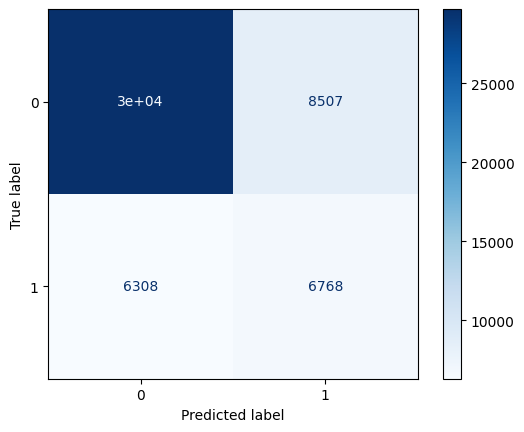

In [18]:
# 예측 확률 계산
IVF_y_pred_proba_catboost = IVF_model_catboost.predict_proba(IVF_X_test)[:, 1]
IVF_y_pred_proba_lgb = IVF_model_lgb.predict_proba(IVF_X_test)[:, 1]
DI_y_pred_proba_lgb = DI_model_lgb.predict_proba(DI_X_test)[:, 1]
DI_y_pred_proba_catboost = DI_model_catboost.predict_proba(DI_X_test)[:, 1]

# 소프트 보팅
IVF_y_pred_proba_combined = (IVF_y_pred_proba_catboost + IVF_y_pred_proba_lgb) / 2
DI_y_pred_proba_combined = (DI_y_pred_proba_lgb + DI_y_pred_proba_catboost) / 2

# 예측 결과 병합
y_test = pd.concat([IVF_y_test, DI_y_test])
y_pred_proba = pd.concat([pd.Series(IVF_y_pred_proba_combined, index=IVF_y_test.index), pd.Series(DI_y_pred_proba_combined, index=DI_y_test.index)])
y_pred = (y_pred_proba >= 0.5).astype(int)

# 평가
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

## 제출

In [19]:
# # 모델 구축
# IVF_model_catboost = CatBoostClassifier(
#     iterations=1695,
#     depth=4,
#     learning_rate=0.05409861221944563,
#     l2_leaf_reg=2.8407951389685064,
#     bagging_temperature=0.3683084175511176,
#     random_strength=1.1750568527543825,
#     scale_pos_weight=3.3095659416645313,
#     border_count=92,
#     logging_level='Silent',
#     random_state=42
# )

# IVF_model_lgb = lgb.LGBMClassifier(
#     n_estimators=1258,
#     num_leaves=923,
#     max_depth=5,
#     learning_rate=0.024413717866391526,
#     min_child_samples=105,
#     subsample=0.4890106069104924,
#     colsample_bytree=0.4494069713807123,
#     reg_alpha=3.0197481977859035,
#     reg_lambda=0.4793565720612017,
#     min_split_gain=0.29685405151668676,
#     random_state=42,
#     boosting_type='gbdt',
#     verbose=-1
# )

# DI_model_catboost = CatBoostClassifier(
#     iterations=2746,
#     depth=6,
#     learning_rate=0.02714910886494123,
#     l2_leaf_reg=0.9438940902410613,
#     bagging_temperature=0.05474176562660327,
#     random_strength=6.694445412295597,
#     scale_pos_weight=3.5493379241640897,
#     border_count=183,
#     logging_level='Silent',
#     random_state=42
# )

# DI_model_lgb = lgb.LGBMClassifier(
#     n_estimators=2443,
#     num_leaves=280,
#     max_depth=149,
#     learning_rate=0.061743249432816755,
#     min_child_samples=176,
#     subsample=0.9103802819067428,
#     colsample_bytree=0.6636673663468106,
#     reg_alpha=0.01173260476029451,
#     reg_lambda=59.000778013447324,
#     min_split_gain=1.1755604684312402,
#     random_state=42,
#     boosting_type='gbdt',
#     verbose=-1
# )

# 모델 학습 및 예측
IVF_model_catboost.fit(IVF_X, IVF_y)
IVF_model_lgb.fit(IVF_X, IVF_y)
IVF_pred_proba_catboost = IVF_model_catboost.predict_proba(IVF_test.drop('ID', axis=1))[:, 1]
IVF_pred_proba_lgb = IVF_model_lgb.predict_proba(IVF_test.drop('ID', axis=1))[:, 1]
IVF_pred_proba = (IVF_pred_proba_catboost + IVF_pred_proba_lgb) / 2

DI_model_catboost.fit(DI_X, DI_y)
DI_model_lgb.fit(DI_X, DI_y)
DI_pred_proba_catboost = DI_model_catboost.predict_proba(DI_test.drop('ID', axis=1))[:, 1]
DI_pred_proba_lgb = DI_model_lgb.predict_proba(DI_test.drop('ID', axis=1))[:, 1]
DI_pred_proba = (DI_pred_proba_catboost + DI_pred_proba_lgb) / 2

In [20]:
# 예측 결과 병합
IVF_test['probability'] = IVF_pred_proba
DI_test['probability'] = DI_pred_proba

# 최종 제출 파일 생성
submission = pd.concat([IVF_test[['ID', 'probability']], DI_test[['ID', 'probability']]], axis=0)
submission = submission.sort_values(by='ID')

# 제출 파일 저장
submission.to_csv('./code16_lgbmNcat.csv', index=False, encoding='utf-8')

.